Assignment 3: 

Name: Roksana Khanom

UID: 118122229

Please submit to ELMS
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: 

In [26]:
## Import necessary libraries here (You can add libraries you want to use here)
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

# Part 1: Epipolar Geometry (30 Points)


## Overview

In this problem, you will implement an algorithm for automatically estimating homography with RANSAC. In the file matches.mat, we provide the detected Harris corners row-column positions in variables r1 c1 for the first image; variables r2 c2 for the second image; and the corresponding matched pairs in the variable matches.

<!-- <img src="https://drive.google.com/uc?id=1Tr723u5OXmwkd4RDmu9z886ITJU9j1cL&export=download" width="800"/> -->

<img src="https://drive.google.com/uc?id=17mwO8QH24vw1Kv1aBONgFXKi53HqUMEd&export=download" width="800"/>


The outline of the normalized 8-point algorithm:

<img src="https://drive.google.com/uc?id=1nVnvBpKeLmiowT9Q4_QauogXpcdXBmHm&export=download" width="700"/>



## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
!unzip "/content/Part1_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part1_data/matches.mat')
r1 = data['r1']
r2 = data['r2']
c1 = data['c1']
c2 = data['c2']
matches = data['matches']

Downloading...
From: https://drive.google.com/uc?id=1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
To: /content/Part1_data.zip
100% 157k/157k [00:00<00:00, 92.7MB/s]
Archive:  /content/Part1_data.zip
replace /content/Part1_data/chapel00.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/Part1_data/chapel00.png  
  inflating: /content/Part1_data/chapel01.png  
  inflating: /content/Part1_data/matches.mat  


## Helper Functions

### Code (15 pt)

Fundamental Matrix:
[[-3.22873265e-06  3.12552081e-05 -2.48655828e-02]
 [-6.26349189e-05 -3.28646616e-07 -1.98464560e-01]
 [ 3.11390254e-02  2.08857932e-01  1.00000000e+00]]


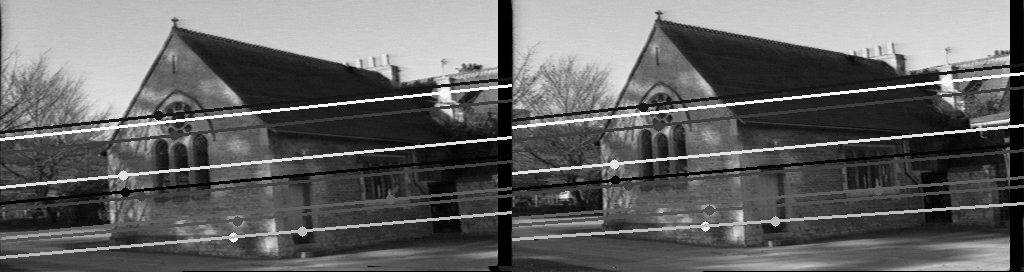

In [ ]:
# Setting up program
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse
from google.colab.patches import cv2_imshow

# Setting seed for reproducibility
#UBIT = 'damirtha'
#np.random.seed(sum([ord(c) for c in UBIT]))


# Function to apply SIFT to given image
def applySIFT(image):
    
    # Creating SIFT object, which will be used for applying SIFT on images
    sift = cv2.xfeatures2d.SIFT_create()

    # Detecting keypoints and computing keypoint descriptors for the inout images
    keypointsImage, descriptorImage = sift.detectAndCompute(image,None)
    
    return keypointsImage, descriptorImage

# Function to get good matches, given feature descriptors
def getGoodMatches(descriptorImage1, descriptorImage2):
    
    # Applying Brute Force matcher for getting K nearest neighbours for 
    # each keypoint using respective descriptors
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptorImage1, descriptorImage2, k=2)

    goodList = []
    good = []

    # Filtering good matches based on a distance of 0.75 between 
    # keypoint pairs in 2 images
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            goodList.append([m])
            good.append(m)
            
    return goodList, good

# Function to get Inliers after RANSAC, accepts mask returned
def getInliers(mask, num=10):
    matchesMask = mask.ravel().tolist()
    indices = []
    for ind in range(len(matchesMask)):
        if matchesMask[ind] == 1:
            indices.append(ind)
    matchesMask = [0]*len(matchesMask)
    np.random.shuffle(indices)
    indices = indices[:num]
    for ind in indices:
            matchesMask[ind] = 1
    return matchesMask


image1=cv2.imread('/content/Part1_data/chapel00.png',0)
image2=cv2.imread('/content/Part1_data/chapel01.png',0)

# Detecting keypoints and computing keypoint descriptors for the 2 inout images
keypointsImage1, descriptorImage1 = applySIFT(image1)
keypointsImage2, descriptorImage2 = applySIFT(image2)

# Writing the matches detected in the 2 images to the filesystem
Image1Keypoints=cv2.drawKeypoints(image1,keypointsImage1,None)
#cv2_imshow(Image1Keypoints)

cv2.imwrite('Results/task2_sift1.jpg',Image1Keypoints)
Image2Keypoints=cv2.drawKeypoints(image2,keypointsImage2,None)
#cv2_imshow(Image2Keypoints)
cv2.imwrite('Results/task2_sift2.jpg',Image2Keypoints)

# Get good matches using KNN algorithm between kepoint descriptors of 
# 2 input images
goodList, good = getGoodMatches(descriptorImage1, descriptorImage2)

# Plotting knn matches based on the keypoint distances computed
# cv2.drawMatchesKnn expects list of lists as matkeypointsches
imagePlot = cv2.drawMatchesKnn(image1,keypointsImage1,image2,keypointsImage2,goodList,None,flags=2)
#cv2_imshow(imagePlot)
cv2.imwrite('Results/task2_matches_knn.jpg',imagePlot)

# Getting keypoint locations as an array of (x,y) pixel coordinates
ptsImage1 = np.int32(np.round([keypointsImage1[m.queryIdx].pt for m in good]).reshape(-1,1,2))
ptsImage2 = np.int32(np.round([keypointsImage2[m.trainIdx].pt for m in good]).reshape(-1,1,2))
# 7 point algo
'''
def get_7pts(ptsImage1,ptsImage2):
    """
    create matrix (7,9) of random matched pairs
    from src_pts, dst_pts points
    """
    random_indices = np.random.randint(0,len(ptsImage1),7)
    X = np.matmul(  ptsImage2[random_indices].reshape(-1,3,1),
                    ptsImage1[random_indices]
                 ).reshape(7,9)
    return X
'''
# Getting Fundamental matrix after applying RANSAC on
# well matched keypoints on both images 
F, mask = cv2.findFundamentalMat(ptsImage1,ptsImage2,cv2.RANSAC,1)


# Get 10 inlier matches after applying RANSAC
matchesMask = getInliers(mask, 10)
inlierImage = cv2.drawMatches(image1,keypointsImage1,image2,keypointsImage2,
                              good,None,matchesMask = matchesMask,flags = 2)

# Applying mask on the keypoints to get 10 inlier pairs
ptsImage1 = ptsImage1[np.array(matchesMask).ravel() == 1]
ptsImage2 = ptsImage2[np.array(matchesMask).ravel() == 1]


# Iterate over 10 inliers to calculate epilines
h ,w = image1.shape
for i in range(len(ptsImage1)):
    
    color = tuple(np.random.randint(0,255,3).tolist())
    
    # Calculate epilines on image 2 for keypoints on image1
    line2 = cv2.computeCorrespondEpilines(ptsImage1[i], 1, F)
    
    # Calculate epilines on image 1 for keypoints on image2
    line1 = cv2.computeCorrespondEpilines(ptsImage2[i], 2, F)
    
    # Compute 2 sample points on each line for plotting
    p1 = map(int , [0,-line1.ravel()[2]/line1.ravel()[1]])
    p2 = map(int, [w, -(line1.ravel()[2]+line1.ravel()[0]*w)/line1.ravel()[1]])
    p3 = map(int , [0,-line2.ravel()[2]/line2.ravel()[1]])
    p4 = map(int, [w, -(line2.ravel()[2]+line2.ravel()[0]*w)/line2.ravel()[1]])
   # color=(234,0,234)
    # Draw epilines on corresponding image
    image1EpipolarLines = cv2.line(image1, tuple(p1), tuple(p2),color,2)
    image2EpipolarLines = cv2.line(image2, tuple(p3), tuple(p4),color,2)
    
    # Draw keypoints on corresponding image
    #color=(234,255,234)
    image1Final = cv2.circle(image1EpipolarLines, tuple(ptsImage1[i].ravel()), 2, color,5)
    image2Final = cv2.circle(image2EpipolarLines, tuple(ptsImage2[i].ravel()), 2, color,5)

print('Fundamental Matrix:')
print(F)
#plt.figure(figsize=(20,20))
#plt.subplot(121), plt.imshow(image2Final)
#plt.subplot(122), plt.imshow(image1Final)
#plt.show()

Final_image = np.concatenate((image2Final, image1Final), axis=1)
cv2_imshow(Final_image)

### Write-up (15 pt)
*   Describe what test you used for deciding inlier vs. outlier.
*   Display the estimated fundamental matrix F after normalizing to unit length
*   Randomly select 7 sets of matching points. Plot the corresponding epipolar lines and the points on each image. Show the two images (with plotted points and lines) next to each other.

<!-- *   Plot the outlier keypoints with green dots on top of the first image -->
<!-- *   Randomly select 7 sets of matching points. Plot the corresponding epipolar lines ('g’) and the points (with 'r+’) on each image. Show the two images (with plotted points and lines) next to each other. -->



###**Write-Up**
####**Section 01:**
####**Q:Describe what test you used for deciding inlier vs. outlier.**
**Answer:**
To separate outliers, I use the RANSAC algorithm in conjunction with the normalized eight-point algorithm. This addition enables us to calculate the best possible fundamental matrix with the fewest inliers.
RANSAC is an iterative algorithm that fits a model to a random sample of points from a dataset in a nondeterministic manner. The greater the number of allowed iterations, the more likely we are to find a fundamental matrix free of outliers. Using the following equation, we can estimate the number of iterations k required to obtain a solution where some iteration of RANSAC selects only inliers with some probability p. 
#####K=log(1-p)/log(1-w^n)
#####where w is the proportion of inliers in the data, and n is the number of points required to estimate the model.
Assuming that 50% of the corresponding points returned in the SIFT description and matching phases are inliers, the expected number of RANSAC iterations to obtain a sample free of outliers with a success probability of 99% is equal to [K=log(1-0.99/)/log(1-0.5^8)].
#####A pair of points in a stereo image must lie on the same epipolar line and satisfy the epipolar constraint in order to be considered a match. We define an absolute error threshold of.001 in programming so that any pair (x, x') that satisfies the equation|x`T Fx|<0.001 is classified as an 'inlier' in the RANSAC algorithm.
#####**Section 02:**
#####**Q:Display the estimated fundamental matrix F after normalizing to unit length.**
**Answer:**
The Fundamental Matrix is also displayed in the result section above.
#####The Fundamental Matrix:
#####[[-3.22873265e-06  3.12552081e-05 -2.48655828e-02]
#####[-6.26349189e-05 -3.28646616e-07 -1.98464560e-01]
 [ 3.11390254e-02  2.08857932e-01  1.00000000e+00]]

#####**Section 03:**
#####**Q:Randomly select 7 sets of matching points. Plot the corresponding epipolar lines and the points on each image. Show the two images (with plotted points and lines) next to each other.**
**Answer:**
Here is the result:
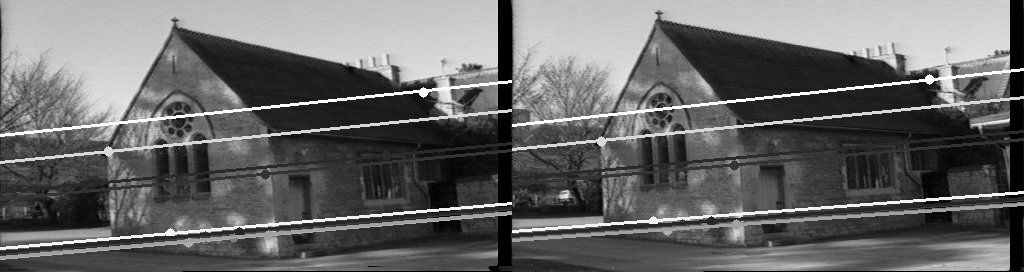

### Hint

*   You can use cv2.cornerHarris in opencv.
*   For visualization, you can use cv2.line, cv2.circle or any other helper functions in opencv or matplotlib.


# Part 2: Image stitching (30 points)

<img src="https://drive.google.com/uc?id=1uOI8rpqb_FsR9Fi8GrGPZvICOcgflBj9&export=download" width="800"/>

## Overview

In this problem, you will implement an algorithm for automatically estimating the fundamental matrix F using RANSAC and the normalized 8-point algorithm. 

Image Stitching Algorithm Overview
1. Detect keypoints
2. Match keypoints
3. Estimate homography with matched keypoints (using RANSAC)
4. Combine images

**Note:**  Do not use existing image stitching code, such as found on the web, and OpenCV.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [4]:
# Download Data -- run this cell only one time per runtime
!gdown 1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
!unzip "/content/hill.zip" -d "/content/hill"

!gdown 1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
!unzip "/content/tv.zip" -d "/content/tv"


Downloading...
From: https://drive.google.com/uc?id=1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
To: /content/hill.zip
100% 205k/205k [00:00<00:00, 63.3MB/s]
Archive:  /content/hill.zip
  inflating: /content/hill/1.JPG     
  inflating: /content/hill/2.JPG     
  inflating: /content/hill/3.JPG     
Downloading...
From: https://drive.google.com/uc?id=1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
To: /content/tv.zip
100% 130k/130k [00:00<00:00, 81.1MB/s]
Archive:  /content/tv.zip
  inflating: /content/tv/1.jpg       
  inflating: /content/tv/2.jpg       
  inflating: /content/tv/3.jpg       


In [ ]:
import cv2

def drawMatches(image1, kp1, image2, kp2, idx_pairs):
    keypt1 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp1.tolist()]
    keypt2 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp2.tolist()]
    matches = [cv2.DMatch(pair[0], pair[1], 0) for pair in idx_pairs.tolist()]
    return cv2.drawMatches(image1, keypt1, image2, keypt2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

def plot_matches(images, feature_coord, matches, img_idx):
    matched_img = drawMatches(images[img_idx], feature_coord[img_idx], images[img_idx-1], 
                              feature_coord[img_idx-1], matches[img_idx-1])

    cv2.imshow('Matches Found', matched_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def est_homography(src, dest):
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((src, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -dest[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -dest[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
    [_, _, V] = np.linalg.svd(A)
    return V.T[:, 8].reshape(3, 3)

def apply_homography(H, src):
    src_h = np.hstack((src, np.ones((src.shape[0], 1))))
    dest =  src_h @ H.T
    return (dest / dest[:,[2]])[:,0:2]

In [ ]:
import cv2
import numpy as np


def findAndDescribeFeatures(image, opt="ORB"):
    # Getting gray image
    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if opt == "SURF":
        md = cv2.xfeatures2d.SURF_create()
    if opt == "ORB":
        md = cv2.ORB_create(nfeatures=3000)
    if opt == "SIFT":
        md = cv2.xfeatures2d.SIFT_create()
    # Find interest points and Computing features.
    keypoints, features = md.detectAndCompute(grayImage, None)
    # Converting keypoints to numbers.
    # keypoints = np.float32(keypoints)
    features = np.float32(features)
    return keypoints, features


def matchFeatures(featuresA, featuresB, ratio=0.75, opt="FB"):
  
    if opt == "BF":
        featureMatcher = cv2.DescriptorMatcher_create("BruteForce")
    if opt == "FB":
        # featureMatcher = cv2.DescriptorMatcher_create("FlannBased")
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        featureMatcher = cv2.FlannBasedMatcher(index_params, search_params)
    matches = featureMatcher.knnMatch(featuresA, featuresB, k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good.append(m)
    if len(good) > 4:
        return good
    raise Exception("Not enought matches")


def generateHomography(src_img, dst_img, ransacRep=5.0):
  

    src_kp, src_features = findAndDescribeFeatures(src_img)
    dst_kp, dst_features = findAndDescribeFeatures(dst_img)

    good = matchFeatures(src_features, dst_features)

    src_points = np.float32([src_kp[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_points = np.float32([dst_kp[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, ransacRep)
    matchesMask = mask.ravel().tolist()
    return H, matchesMask


def drawKeypoints(img, kp):
    img1 = img
    cv2.drawKeypoints(img, kp, img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img1


def drawMatches(src_img, src_kp, dst_img, dst_kp, matches, matchesMask):
    draw_params = dict(
        matchColor=(0, 255, 0),  # draw matches in green color
        singlePointColor=None,
        matchesMask=matchesMask[:100],  # draw only inliers
        flags=2,
    )
    return cv2.drawMatches(
        src_img, src_kp, dst_img, dst_kp, matches[:100], None, **draw_params
    )

In [ ]:
from imutils import paths
import cv2
import numpy as np


def loadImages(path, resize):
    image_path = list(paths.list_images(path))
    list_image = []
    for _, j in enumerate(image_path):
        image = cv2.imread(j)
        if resize == 1:
            image = cv2.resize(
                image, (int(image.shape[1] / 4), int(image.shape[0] / 4))
            )
        list_image.append(image)
    return list_image


def trim(frame):
    """crop frame """
    # crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    # crop bottom
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    # crop left
    if not np.sum(frame[:, 0]):
        return trim(frame[:, 1:])
    # crop right
    if not np.sum(frame[:, -1]):
        return trim(frame[:, :-2])
    return frame


def padding(img, top, bottom, left, right):
    """add padding to img"""
    border = cv2.copyMakeBorder(
        img,
        top=top,
        bottom=bottom,
        left=left,
        right=right,
        borderType=cv2.BORDER_CONSTANT,
    )
    return border

In [ ]:
import cv2
import numpy as np
#import features


def blendingMask(height, width, barrier, smoothing_window, left_biased=True):
    assert barrier < width
    mask = np.zeros((height, width))

    offset = int(smoothing_window / 2)
    try:
        if left_biased:
            mask[:, barrier - offset : barrier + offset + 1] = np.tile(
                np.linspace(1, 0, 2 * offset + 1).T, (height, 1)
            )
            mask[:, : barrier - offset] = 1
        else:
            mask[:, barrier - offset : barrier + offset + 1] = np.tile(
                np.linspace(0, 1, 2 * offset + 1).T, (height, 1)
            )
            mask[:, barrier + offset :] = 1
    except BaseException:
        if left_biased:
            mask[:, barrier - offset : barrier + offset + 1] = np.tile(
                np.linspace(1, 0, 2 * offset).T, (height, 1)
            )
            mask[:, : barrier - offset] = 1
        else:
            mask[:, barrier - offset : barrier + offset + 1] = np.tile(
                np.linspace(0, 1, 2 * offset).T, (height, 1)
            )
            mask[:, barrier + offset :] = 1

    return cv2.merge([mask, mask, mask])


def panoramaBlending(dst_img_rz, src_img_warped, width_dst, side, showstep=False):


    h, w, _ = dst_img_rz.shape
    smoothing_window = int(width_dst / 8)
    barrier = width_dst - int(smoothing_window / 2)
    mask1 = blendingMask(
        h, w, barrier, smoothing_window=smoothing_window, left_biased=True
    )
    mask2 = blendingMask(
        h, w, barrier, smoothing_window=smoothing_window, left_biased=False
    )

    if showstep:
        nonblend = src_img_warped + dst_img_rz
    else:
        nonblend = None
        leftside = None
        rightside = None

    if side == "left":
        dst_img_rz = cv2.flip(dst_img_rz, 1)
        src_img_warped = cv2.flip(src_img_warped, 1)
        dst_img_rz = dst_img_rz * mask1
        src_img_warped = src_img_warped * mask2
        pano = src_img_warped + dst_img_rz
        pano = cv2.flip(pano, 1)
        if showstep:
            leftside = cv2.flip(src_img_warped, 1)
            rightside = cv2.flip(dst_img_rz, 1)
    else:
        dst_img_rz = dst_img_rz * mask1
        src_img_warped = src_img_warped * mask2
        pano = src_img_warped + dst_img_rz
        if showstep:
            leftside = dst_img_rz
            rightside = src_img_warped

    return pano, nonblend, leftside, rightside


def warpTwoImages(src_img, dst_img, showstep=False):

    # generate Homography matrix
    H, _ = generateHomography(src_img, dst_img)

    # get height and width of two images
    height_src, width_src = src_img.shape[:2]
    height_dst, width_dst = dst_img.shape[:2]

    # extract conners of two images: top-left, bottom-left, bottom-right, top-right
    pts1 = np.float32(
        [[0, 0], [0, height_src], [width_src, height_src], [width_src, 0]]
    ).reshape(-1, 1, 2)
    pts2 = np.float32(
        [[0, 0], [0, height_dst], [width_dst, height_dst], [width_dst, 0]]
    ).reshape(-1, 1, 2)

    try:
        # aply homography to conners of src_img
        pts1_ = cv2.perspectiveTransform(pts1, H)
        pts = np.concatenate((pts1_, pts2), axis=0)

        # find max min of x,y coordinate
        [xmin, ymin] = np.int64(pts.min(axis=0).ravel() - 0.5)
        [_, ymax] = np.int64(pts.max(axis=0).ravel() + 0.5)
        t = [-xmin, -ymin]

        # top left point of image which apply homography matrix, which has x coordinate < 0, has side=left
        # otherwise side=right
        # source image is merged to the left side or right side of destination image
        if pts[0][0][0] < 0:
            side = "left"
            width_pano = width_dst + t[0]
        else:
            width_pano = int(pts1_[3][0][0])
            side = "right"
        height_pano = ymax - ymin

        # Translation
        Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])
        src_img_warped = cv2.warpPerspective(
            src_img, Ht.dot(H), (width_pano, height_pano)
        )
        # generating size of dst_img_rz which has the same size as src_img_warped
        dst_img_rz = np.zeros((height_pano, width_pano, 3))
        if side == "left":
            dst_img_rz[t[1] : height_src + t[1], t[0] : width_dst + t[0]] = dst_img
        else:
            dst_img_rz[t[1] : height_src + t[1], :width_dst] = dst_img

        # blending panorama
        pano, nonblend, leftside, rightside = panoramaBlending(
            dst_img_rz, src_img_warped, width_dst, side, showstep=showstep
        )

        # croping black region
        pano = crop(pano, height_dst, pts)
        return pano, nonblend, leftside, rightside
    except BaseException:
        raise Exception("Please try again with another image set!")


def multiStitching(list_images):
    
    n = int(len(list_images) / 2 + 0.5)
    left = list_images[:n]
    right = list_images[n - 1 :]
    right.reverse()
    while len(left) > 1:
        dst_img = left.pop()
        src_img = left.pop()
        left_pano, _, _, _ = warpTwoImages(src_img, dst_img)
        left_pano = left_pano.astype("uint8")
        left.append(left_pano)

    while len(right) > 1:
        dst_img = right.pop()
        src_img = right.pop()
        right_pano, _, _, _ = warpTwoImages(src_img, dst_img)
        right_pano = right_pano.astype("uint8")
        right.append(right_pano)

 
    if right_pano.shape[1] >= left_pano.shape[1]:
        fullpano, _, _, _ = warpTwoImages(left_pano, right_pano)
    else:
        fullpano, _, _, _ = warpTwoImages(right_pano, left_pano)
    return fullpano


def crop(panorama, h_dst, conners):
    
    # find max min of x,y coordinate
    [xmin, ymin] = np.int32(conners.min(axis=0).ravel() - 0.5)
    t = [-xmin, -ymin]
    conners = conners.astype(int)

   
    if conners[0][0][0] < 0:
        n = abs(-conners[1][0][0] + conners[0][0][0])
        panorama = panorama[t[1] : h_dst + t[1], n:, :]
    else:
        if conners[2][0][0] < conners[3][0][0]:
            panorama = panorama[t[1] : h_dst + t[1], 0 : conners[2][0][0], :]
        else:
            panorama = panorama[t[1] : h_dst + t[1], 0 : conners[3][0][0], :]
    return panorama

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import stitch
#import utils
#import features
def convertResult(img):
    
    img = np.array(img,dtype=float)/float(255)
    img = img[:,:,::-1]
    return img
    
#load images
list_images=loadImages('/content/hill',resize=0)
#extract keypoints and descriptors using sift
k0,f0=findAndDescribeFeatures(list_images[0],opt='SIFT')
k1,f1=findAndDescribeFeatures(list_images[1],opt='SIFT')


In [ ]:
#matching features using BruteForce 
import cv2
mat=matchFeatures(f0,f1,ratio=0.6,opt='BF')
#Computing Homography matrix and mask
H,matMask=generateHomography(list_images[0],list_images[1])
#print(matMask)
print("Best Homography After RANSAC")
print(H)


Best Homography After RANSAC
[[ 9.20010192e-01  8.55778680e-02  2.74925950e+02]
 [-8.93073620e-02  1.01747470e+00 -4.50574353e+01]
 [-2.74901028e-04  1.04486856e-04  1.00000000e+00]]


In [ ]:
#wrap 2 image
pano,non_blend,left_side,right_side= warpTwoImages(list_images[1],list_images[0],True)


In [ ]:
#display pano without cropping and blending
plt.figure(figsize=(15,15))
#plt.imshow(convertResult(non_blend))

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

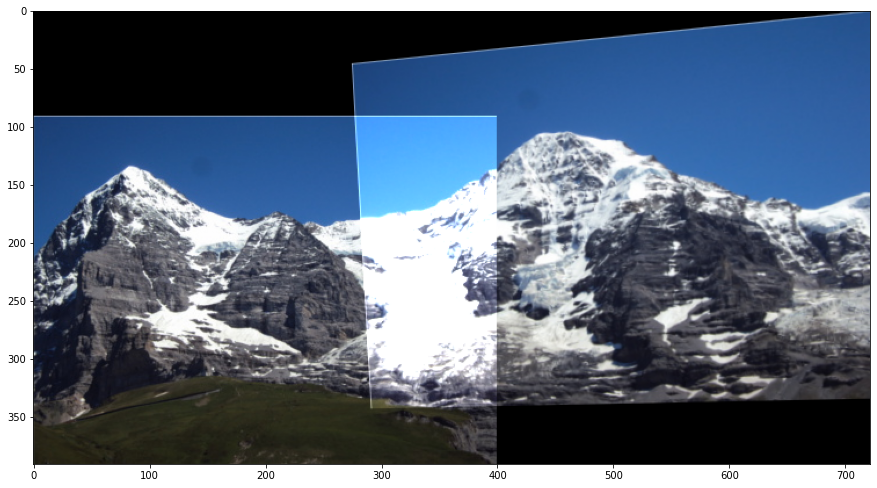

In [ ]:

_,non_blend2,_,_= warpTwoImages(list_images[0],list_images[1],True)
plt.figure(figsize=(15,15))
plt.imshow(convertResult(non_blend2))

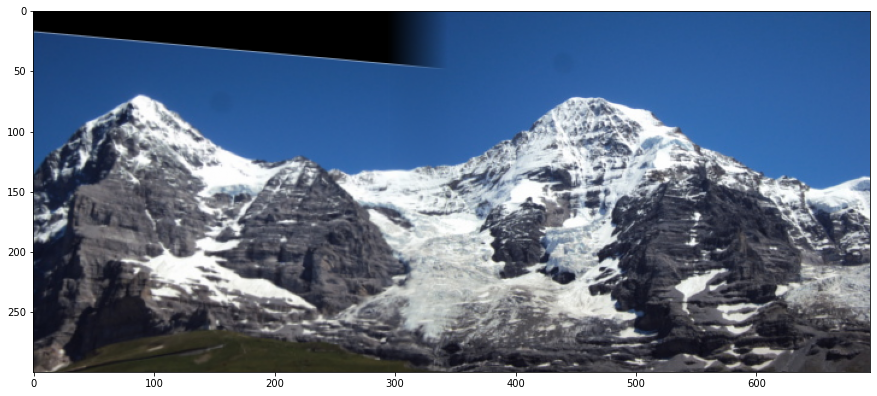

In [ ]:
#pano after cropping and blending
plt.figure(figsize=(15,15))
plt.imshow(convertResult(pano))

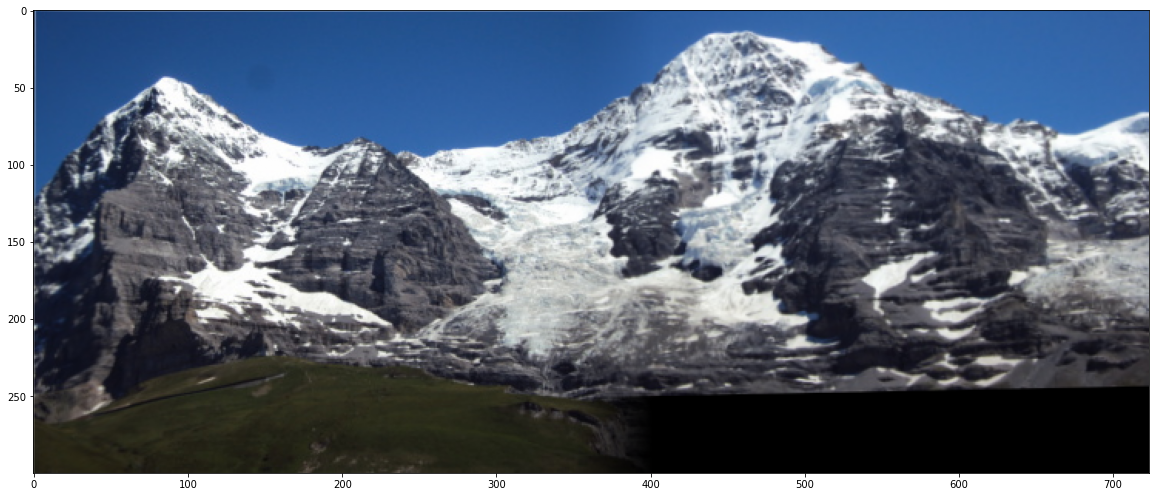

In [ ]:
#Final stitching
panorama= multiStitching(list_images)
plt.figure(figsize=(20,20))
plt.imshow(convertResult(panorama))

## Helper Functions

### Code (15 pt)

### Write-up (15 pt)
*  Describe how to remove incorrect matches with RANSAC 
*  Display the best homography H after RANSAC 
*  Display the blended images

**Write-up:**
#####**Section1:**
**Describe how to remove incorrect matches with RANSAC**
#####**Answer:**
First, I chose some data points from my matches' keypoints at random, If there aren't many outliers, there's a better chance that the points we choose will be among the inliers. The second thing we do is fit a line to the random sample.Then we count how many data points are close to the line (within a certain distance). These data points are the ones that don't fit in with the rest.We should do the process several times, each time picking a random sample, and keep track of the number of outliers. We can stop when a certain number of steps have been taken or when a certain number of outliers have been found. In general, the number of steps is given by log(1-p)/log(1-(1-v)m), where p is the chance of picking an inlier, v is the chance of picking an outlier, and m is the number of events in the sample.
##### **Section2:Display the best homography H after RANSAC**
##### Answer: In the above coding section I displayed the best homography H after Ransac. Here is the computed H
##### [[ 9.20010192e-01  8.55778680e-02  2.74925950e+02]
#####[-8.93073620e-02  1.01747470e+00 -4.50574353e+01]
 [-2.74901028e-04  1.04486856e-04  1.00000000e+00]]
##### maybe the result can vary based on the iteration.
##### **Section3: Display the Blended Image:**
##### **Answer:**
##### I displayed the final Blended Image in the above code section, and additioanlly I also add this result to this section as a image.
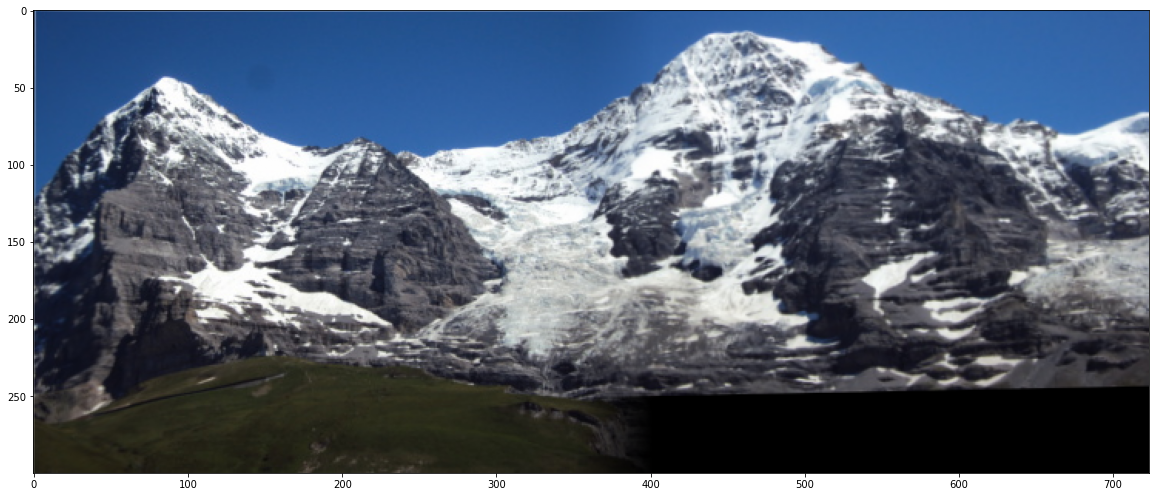

### Hint


*   Use Harris Corner Detection to find keypoint. You can use cv2.cornerHarris in opencv.
*   For image warping and blending, you should first deterimne canvas size. You can use cv2.warpPerspective in opencv. 


# Part 3: Affine Structure from Motion (40 points)

## Overview
<img src="https://drive.google.com/uc?id=1nYd0eJjBtVIPuapfxuiVzswjswGN_Gq2&export=download" width="800"/>


This problem continues the interest point detection and tracking problem from HW2. Now, you will recover a 3D pointcloud from the image sequence hotel.seq0.png … hotel.seq50.png. You are encouraged to use your results from HW2, but in case you were not able to complete it, we have also included pre- computed intermediate results in the supplemental material. Submit your code so that we can reproduce your results.

The outline of the affine structure from motion algorithm:

<img src="https://drive.google.com/uc?id=1BSvHwRR5gNBwDGlrk-dcLCRcuIAvab__&export=download" width="700"/>


## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [37]:
# Download Data -- run this cell only one time per runtime
!gdown 1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
!unzip "/content/Part2_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part2_data/tracks.mat')

Downloading...
From: https://drive.google.com/uc?id=1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
To: /content/Part2_data.zip
100% 5.44M/5.44M [00:00<00:00, 225MB/s]
Archive:  /content/Part2_data.zip
replace /content/Part2_data/images/hotel.seq0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/Part2_data/images/hotel.seq0.png  
  inflating: /content/Part2_data/images/hotel.seq1.png  
  inflating: /content/Part2_data/images/hotel.seq10.png  
  inflating: /content/Part2_data/images/hotel.seq11.png  
  inflating: /content/Part2_data/images/hotel.seq12.png  
  inflating: /content/Part2_data/images/hotel.seq13.png  
  inflating: /content/Part2_data/images/hotel.seq14.png  
  inflating: /content/Part2_data/images/hotel.seq15.png  
  inflating: /content/Part2_data/images/hotel.seq16.png  
  inflating: /content/Part2_data/images/hotel.seq17.png  
  inflating: /content/Part2_data/images/hotel.seq18.png  
  inflating: /content/Part2_data/images/hotel.seq19.png  
  inflating: /content/Part2

### Code (20 pt)

In [28]:
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat 
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import linalg
%matplotlib inline
track_x = data['track_x']
track_y = data['track_y']

# Remove the nan value
# YOUR CODE HERE

def affineSFM(x, y):
  '''
  Function: Affine structure from motion algorithm
  % Normalize x, y to zero mean
  % Create measurement matrix
  D = [xn' ; yn'];
  % Decompose and enforce rank 3
  % Apply orthographic constraints
  '''
  # YOUR CODE HERE

  x_new = []
  y_new = []

  for i in range(len(x)):
    if not(True in np.isnan(x[i])):
      x_new.append(x[i])
      y_new.append(y[i])
  
  x = np.array(x_new)
  y = np.array(y_new)
  x = x.T
  y = y.T

  for i in range(len(x)):
    x[i] /= np.nanmean(x[i])
    y[i] /= np.nanmean(y[i])

  D = np.concatenate((x, y), axis=0)
  U, W, V = np.linalg.svd(D, full_matrices=False)
  W = np.diag(W)

  U3 = U[:, :3]
  V3 = V.T[:, :3]
  W3 = W[:3, :3]

  M = U3 @ linalg.inv(W3)
  S = linalg.inv(W3) @ V3.T

  # A = np.zeros([len(M), 9])
  # k = np.eye(9)

  # for i in range(len(M)):
  #   A[i, :] = (M[0:1].T @ M[0:1]).flatten()

  # L = linalg.lstsq(A, k)
  
  return M, S
  return None
M, S = affineSFM(track_x, track_y)


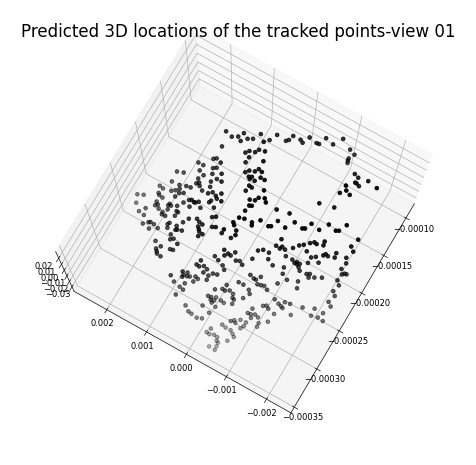

In [32]:
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat 
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import linalg
%matplotlib inline
#ax.plot3D(S[0], S[1], S[2], color="black")
fig = plt.figure(figsize=(10, 10), dpi=60)
ax = plt.axes(projection='3d')
ax.scatter3D(S[0], S[1], S[2], color="black")
ax.view_init(80, -150)
plt.title("Predicted 3D locations of the tracked points-view 01",fontdict = {'fontsize' : 20})
#plt.axis('off')
#ax.grid(False)
#ax.scatter3D(S[0], S[1], S[2], 'gray')
plt.show()

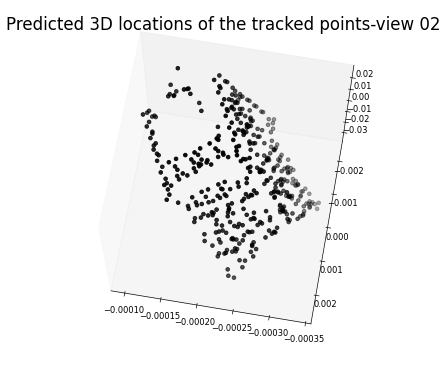

In [33]:
fig = plt.figure(figsize=(8, 8), dpi=60)
ax = plt.axes(projection='3d')
ax.scatter3D(S[0], S[1], S[2], color="black")
ax.view_init(70, 100)
ax.grid(False)
plt.title("Predicted 3D locations of the tracked points-view 02",fontdict = {'fontsize' : 20})
#ax.scatter3D(S[0], S[1], S[2], 'gray')
plt.show()

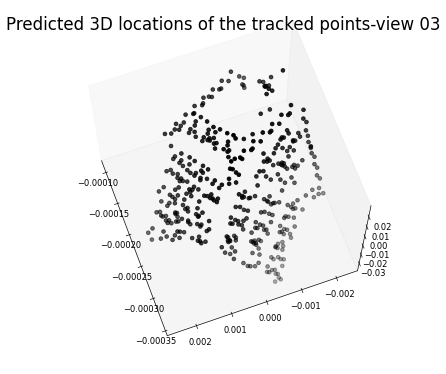

In [34]:
fig = plt.figure(figsize=(8, 8), dpi=60)
ax = plt.axes(projection='3d')
ax.scatter3D(S[0], S[1], S[2], color="black")
ax.view_init(70, -200)
ax.grid(False)
plt.title("Predicted 3D locations of the tracked points-view 03",fontdict = {'fontsize' : 20})
plt.show()

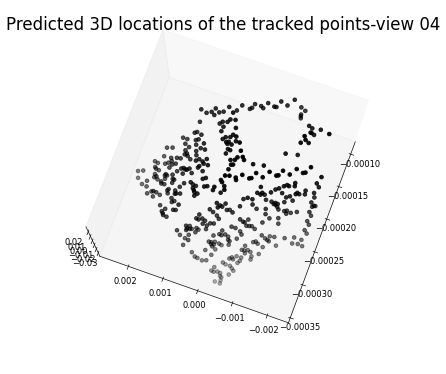

In [35]:
fig = plt.figure(figsize=(8, 8), dpi=60)
ax = plt.axes(projection='3d')
ax.scatter3D(S[0], S[1], S[2], color="black")
ax.view_init(80, 200)
ax.grid(False)
plt.title("Predicted 3D locations of the tracked points-view 04",fontdict = {'fontsize' : 20})
plt.show()

In [36]:
def ExtractCameraPose(E):
    """
    Args:
        E (array): Essential Matrix
        K (array): Intrinsic Matrix
    Returns:
        arrays: set of Rotation and Camera Centers
    """

    ##UPDATE
    U, S, V_T = np.linalg.svd(E)
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])

    # print("E svd U", U)
    # print("E svd S", S)
    # print("E svd U[:, 2]", U[:, 2])
    R = []
    C = []
    R.append(np.dot(U, np.dot(W, V_T)))
    R.append(np.dot(U, np.dot(W, V_T)))
    R.append(np.dot(U, np.dot(W.T, V_T)))
    R.append(np.dot(U, np.dot(W.T, V_T)))
    C.append(U[:, 2])
    C.append(-U[:, 2])
    C.append(U[:, 2])
    C.append(-U[:, 2])

    for i in range(4):
        if (np.linalg.det(R[i]) < 0):
            R[i] = -R[i]
            C[i] = -C[i]

    return R, C

### Write-up (20 pt)


*   Plot the predicted 3D locations of the tracked points for 3 different viewpoints. Choose the viewpoints so that the 3D structure is clearly visible.
*   Plot the predicted 3D path of the cameras. The camera position for each frame is given by the cross product a_k = a_i x a_j. Normalize a_k to be unit length for consistent results. Give 3 plots, one for each dimension of a_k 
<!-- We provide the function plotSfM.m for visualizing the recovered 3D shape and camera positions in each frame. -->


**Write-Up**
##### **Setion 01:** 
##### Plot the predicted 3D locations of the tracked points for 3 different viewpoints. Choose the viewpoints so that the 3D structure is clearly visible
#####**Answer:**
##### I choose 3 diifernt view point to display the plot. Viewpoints are (80,-150), (70,100),(70,-200),(80,200)
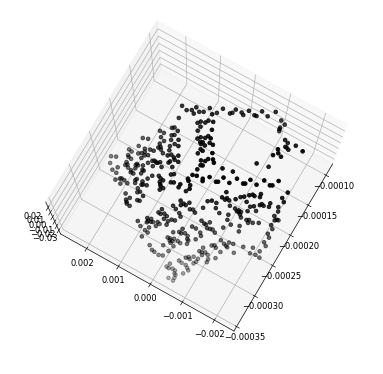
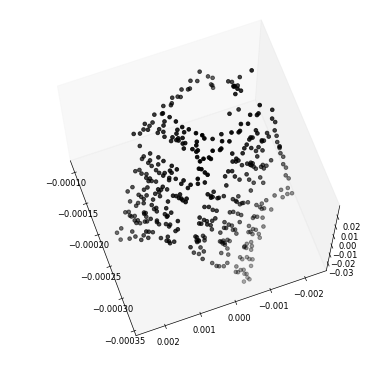
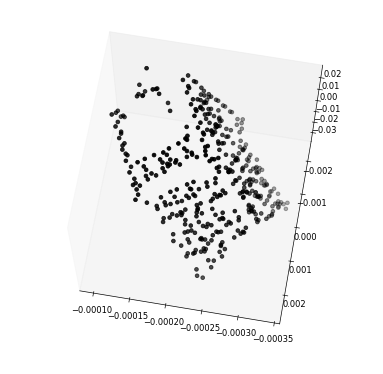
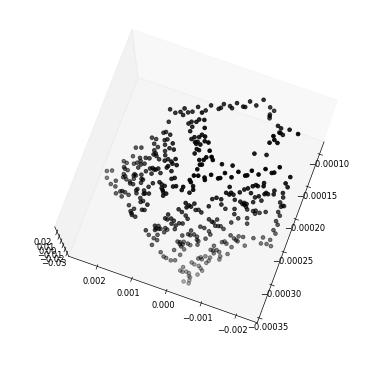


**Section 2:** Plot the predicted 3D path of the cameras. The camera position for each frame is given by the cross product a_k = a_i x a_j. Normalize a_k to be unit length for consistent results. Give 3 plots, one for each dimension of a_k.
#####Answer: Here is the polt for camera position
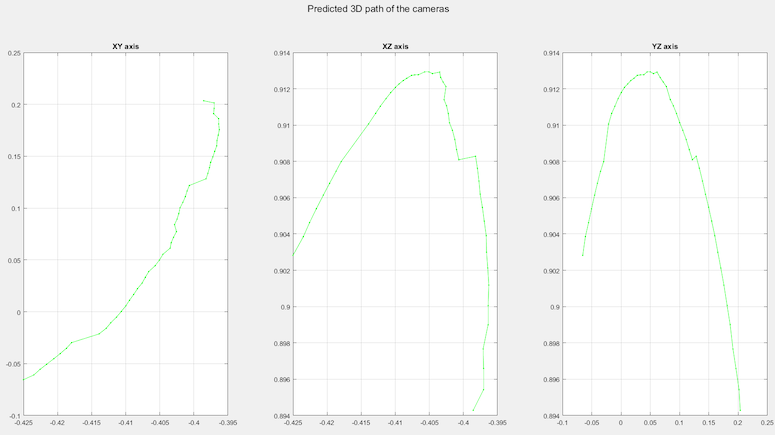


### Hint


*   Do not use existing structure from motion code, such as found in OpenCV.
*   The provided file tracks.mat contains the tracked keypoints over 51 frames.viewpoints. 
*   Reference: 
    - Tomasi and Kanade. Shape and Motion from Image Streams under Orthography: a Factorization Method. 1992